In [8]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
sns.set_style("ticks")

custom_palette = ["black", "red", "green", "orange", "blue"]
sns.set_palette(custom_palette)

model_type = 'EqOdd_thr'
calib_method = 'logx_logreg'
save_plots=True

def get_false_discovery_omission(df):

    discovery_omission = pd.DataFrame(df
                                      .query('(phase=="test")')
                                      .filter(['group', 'treat', 'person_id', 'model_id', 'labels', 'fold_id'])
                                      .assign(f_positive_rate_075 = lambda x: np.where((x.labels==0) & (x.treat>0), 1, 0),
                                              f_negative_rate_075 = lambda x: np.where((x.labels==1) & (x.treat==0), 1, 0),
                                              f_positive_rate_20 = lambda x: np.where((x.labels==0) & (x.treat==2), 1, 0),
                                              f_negative_rate_20 = lambda x: np.where((x.labels==1) & (x.treat<2), 1, 0),
                                              fraction_treated = lambda x: np.where(x.treat>0, 1, 0),
                                             )
                                      .filter(['group', 'model_id', 'fold_id',
                                               'f_positive_rate_075', 'f_negative_rate_075',
                                               'f_positive_rate_20', 'f_negative_rate_20',
                                               'fraction_treated'])
                                      .groupby(['model_id', 'fold_id','group'])
                                      .mean()
                                      .stack()
                                      .reset_index()
                                      .rename(columns={'level_3':'metric', 0:'performance'})
                                     )
    discovery_omission_all = pd.DataFrame(df
                                      .query('(phase=="test")')
                                      .filter(['treat', 'person_id', 'model_id', 'labels', 'fold_id'])
                                      .assign(f_positive_rate_075 = lambda x: np.where((x.labels==0) & (x.treat>0), 1, 0),
                                              f_negative_rate_075 = lambda x: np.where((x.labels==1) & (x.treat==0), 1, 0),
                                              f_positive_rate_20 = lambda x: np.where((x.labels==0) & (x.treat==2), 1, 0),
                                              f_negative_rate_20 = lambda x: np.where((x.labels==1) & (x.treat<2), 1, 0),
                                              fraction_treated = lambda x: np.where(x.treat>0, 1, 0),
                                             )
                                      .filter(['model_id', 'fold_id',
                                               'f_positive_rate_075', 'f_negative_rate_075',
                                               'f_positive_rate_20', 'f_negative_rate_20',
                                               'fraction_treated'])
                                      .groupby(['model_id', 'fold_id'])
                                      .mean()
                                      .stack()
                                      .reset_index()
                                      .rename(columns={'level_2':'metric', 0:'performance'})
                                    .assign(group='all')
                                     )
    return discovery_omission.append(discovery_omission_all)



args = {'cohort_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts/cohort/all_cohorts.csv',
        'base_path': '/labs/shahlab/projects/agataf/data/cohorts/pooled_cohorts',
        'plot_path': os.path.join('/labs/shahlab/projects/agataf/fairness_utility/eval/plots', 'paper_plots'),
        'eval_fold':  'eval',
        'grp_label_dict': {1: 'Black women', 2: 'White women', 3: 'Black men', 4: 'White men'} 
       }

In [2]:
plot_df_all = []

for experiment in ['apr14_mmd', 'apr14_thr']:
    aggregate_path = os.path.join(args['base_path'], 'experiments', 
                                  experiment, 'performance',
                                  'all')
    
    
    preds_path = os.path.join(aggregate_path, 'predictions.csv')

    preds = pd.read_csv(preds_path)
    if 'model_id' not in preds.columns:
        preds = preds.assign(model_id=0)
    if 'fold_id' not in preds.columns:
        preds = preds.assign(fold_id=0)

    discovery_omission = get_false_discovery_omission(preds)
    df_general = pd.read_csv(os.path.join(aggregate_path, 'standard_evaluation.csv'))
    df_fair = pd.read_csv(os.path.join(aggregate_path, 'fairness_evaluation.csv'))
    
    thr_calibs = pd.read_csv(os.path.join(aggregate_path, 'calibration', calib_method, 'calibration_sensitivity_thresholds_raw.csv'))
    
    thr_calibs = (thr_calibs
                  .assign(metric = lambda x: 'outcome_rate_' + x.pred_probs.map({0.075: '075', 0.2: '20'}))
                  .rename(columns = {'calibration_density': 'performance'})
                  .filter(df_fair.columns)
                 )

    plot_df = (df_general
               .append(df_fair)
               .append(thr_calibs)
              )
    
    if 'model_id' not in plot_df.columns:
        plot_df = plot_df.assign(model_id=0)
    if 'fold_id' not in plot_df.columns:
        plot_df = plot_df.assign(fold_id=0)
        

    plot_df = (plot_df
                    .set_index(['model_id','fold_id'], drop=True)
                    .filter(['metric', 'performance_overall', 'performance', 'violation', 'group'])
                    .drop_duplicates()
                    .reset_index()
               .append(discovery_omission)
               .assign(model_type = experiment)
    )  
    
    plot_df_all.append(plot_df)  
    
plot_df_all = pd.concat(plot_df_all)
plot_df_all = plot_df_all.assign(
    model_type = lambda x: x.model_type.map(
        {'original_pce': 'PCE',
         'apr14_erm': 'ERM',
         'apr14_erm_recalib': 'rERM',
         'apr14_mmd': 'EqOdd_mmd',
         'apr14_thr': 'EqOdd_thr'}
    )
)

plot_df_all = (plot_df_all
 .drop(columns=['performance'])
 .assign(group='all')
 .drop_duplicates()
 .rename(columns={'performance_overall': 'performance'})
 .append(plot_df_all)
 .drop(columns=['performance_overall'])
)

In [3]:
to_plot1 = (plot_df_all
           .query("(metric=='auc') | (metric=='auprc') | (metric=='loss_bce')")
           .assign(metric = lambda x: x.metric.map({'auc': 'AUC', 'auprc': 'AUPRC', 'loss_bce': 'loss'}),
                  row='A')
          )
to_plot2 = (plot_df_all
           .query("(metric=='emd_0_ova') | (metric=='emd_1_ova') | (metric=='ace_rmse_logistic_log')")
           .assign(metric = lambda x: x.metric.map({'emd_0_ova': 'EMD (no outcome)',
                             'emd_1_ova': 'EMD (outcome)', 'ace_rmse_logistic_log': 'ACE'}),
                  row='B')
          )

to_plot = to_plot1.append(to_plot2)

In [30]:
a=(plot_df_all
   .query("(metric==['emd_0_ova', 'emd_1_ova'])")
   .groupby(['model_id', 'fold_id', 'model_type']).mean()
   .reset_index()
   .assign(metric = 'eqodds_viol')
   #.rename(columns = {'performance': 'eqodds_viol'})
)
a.head()

b=(plot_df_all
   .query("metric=='ace_rmse_logistic_log'")
   .groupby(['model_id', 'fold_id', 'model_type']).mean()
   .reset_index()
   .assign(metric = 'ace_rmse_viol')
   #.rename(columns = {'performance': 'ace_rmse_viol'})
)
#a.groupby(['model_id', 'fold_id', 'model_type']).mean()
# (a.query("(metric=='emd_0_ova') | (metric=='emd_1_ova') ")
#   .performance
#                                .mean()
# )
tradeoffs = a.append(b)

In [40]:
tradeoffs_toplot = (tradeoffs
                    .pivot(index=['model_id', 'fold_id', 'model_type'], columns='metric', values='performance')
                    .reset_index()
                   )
tradeoffs_toplot.head()

metric,model_id,fold_id,model_type,ace_rmse_viol,eqodds_viol
0,0.001,1,EqOdd_mmd,0.019318,0.022075
1,0.001,1,EqOdd_thr,0.019280,0.022005
2,0.001,2,EqOdd_mmd,0.019872,0.019699
3,0.001,2,EqOdd_thr,0.020074,0.019696
4,0.001,3,EqOdd_mmd,0.022050,0.019414


In [44]:
def is_pareto_efficient_simple(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient



In [64]:
print(i,c)

0 ace_rmse_viol


In [63]:
costs#.reset_index(drop=True)

metric,ace_rmse_viol,eqodds_viol
0,0.019318,0.022075
2,0.019872,0.019699
4,0.022050,0.019414
6,0.023420,0.020027
8,0.019528,0.019487
...,...,...
190,0.027153,0.014412
192,0.026766,0.014015
194,0.030025,0.016167
196,0.031934,0.012543


In [70]:
    costs=np.array(a)
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self

In [103]:
a=tradeoffs_toplot.query("model_type=='EqOdd_mmd'").filter(['ace_rmse_viol', 'eqodds_viol'])
is_efficient = is_pareto_efficient_simple(np.array(a))
frontier_test = a[is_efficient]


In [104]:
frontier_test#.sort_values(by ='eqodds_viol')

metric,ace_rmse_viol,eqodds_viol
0,0.031004,0.012489
1,0.030842,0.012892
2,0.026954,0.012992
3,0.023698,0.013158
4,0.022015,0.013973
5,0.020863,0.015385
6,0.020448,0.016495
7,0.020128,0.016931
8,0.019509,0.018009
9,0.019412,0.021428


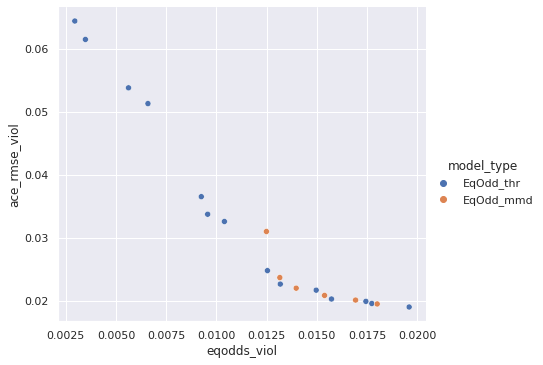

In [119]:
a= (tradeoffs_toplot
    #.query("model_type=='EqOdd_mmd'")
    .filter(['ace_rmse_viol', 'eqodds_viol'])
   )
is_efficient = is_pareto_efficient_simple(np.array(a))
frontier_test = tradeoffs_toplot[is_efficient]
#frontier_test = frontier_test.sort_values(by ='eqodds_viol').reset_index(drop=True)




g = sns.relplot(data = frontier_test,#tradeoffs_toplot.query("model_type=='EqOdd_mmd'"),
                x = 'eqodds_viol',
                y = 'ace_rmse_viol',
                kind = 'scatter',
                #col='model_type',
                hue = 'model_type',
                legend = True,
                #ci='sd',
                marker="o",
                aspect = 1.2,
               )

# g.axes[0,0].plot(frontier_test.eqodds_viol,
#                  frontier_test.ace_rmse_viol,
#                   #marker="o"
#                 )
#index_test = np.argsort(a[is_efficient][:,0])
# frontier_test = a[is_efficient][index_test]

In [79]:
a[is_efficient]

metric,ace_rmse_viol,eqodds_viol
0,0.019318,0.022075
20,0.019329,0.021988
40,0.019353,0.021804
60,0.019412,0.021428
108,0.020128,0.016931
120,0.019509,0.018009
128,0.020863,0.015385
140,0.020448,0.016495
148,0.022015,0.013973
168,0.023698,0.013158


In [78]:
np.argsort(a[is_efficient])

metric,ace_rmse_viol,eqodds_viol
0,0,1
20,0,1
40,0,1
60,0,1
108,1,0
120,1,0
128,1,0
140,1,0
148,1,0
168,1,0


In [4]:
df_threshold_1 = (plot_df_all.query('(metric=="f_positive_rate_075") | \
                                     (metric=="f_negative_rate_075") | \
                                     (metric=="outcome_rate_075")')
                  #(metric=="specificity_0.075") |(metric=="recall_0.075") |\
                                     
                  .assign(threshold='7.5%')
                 )
df_threshold_2 = (plot_df_all.query('(metric=="f_positive_rate_20") | \
                                    (metric=="f_negative_rate_20")| \
                                     (metric=="outcome_rate_20")')
#(metric=="specificity_0.2") | (metric=="recall_0.2") | \
                  .assign(threshold='20%')


                 )


df_thresholds = (df_threshold_1.append(df_threshold_2)
                  .assign(metric=lambda x: x.metric.map({'specificity_0.2': 'specificity',
                                                         'recall_0.2': 'sensitivity',
                                                         'f_positive_rate_20': 'FPR',
                                                         'f_negative_rate_20': 'FNR',
                                                         'specificity_0.075': 'specificity',
                                                         'recall_0.075': 'sensitivity',
                                                         'f_positive_rate_075': 'FPR',
                                                         'f_negative_rate_075': 'FNR',
                                                        'outcome_rate_075': 'outcome rate',
                                                        'outcome_rate_20': 'outcome rate'})
                ))

In [5]:
sns.set(font_scale=1.5)
sns.set_style("ticks")

plot_args = {'x': 'model_id', 
            'y': 'performance',
            'col': 'metric',
            'kind': 'line',
            'palette': custom_palette,
            'hue': 'group',
            'err_style': 'bars',
            'facet_kws': {'sharey': False, 'margin_titles': True},
            'err_kws': {'capsize': 5},
            'legend': False,
            'marker':'o',
            'aspect':1}

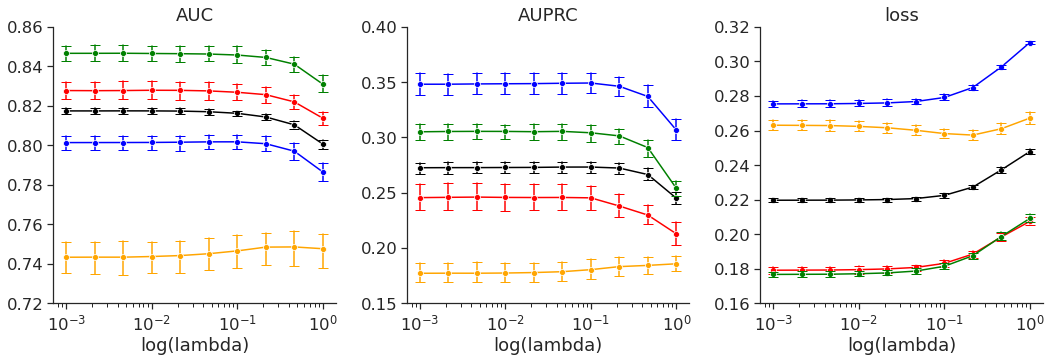

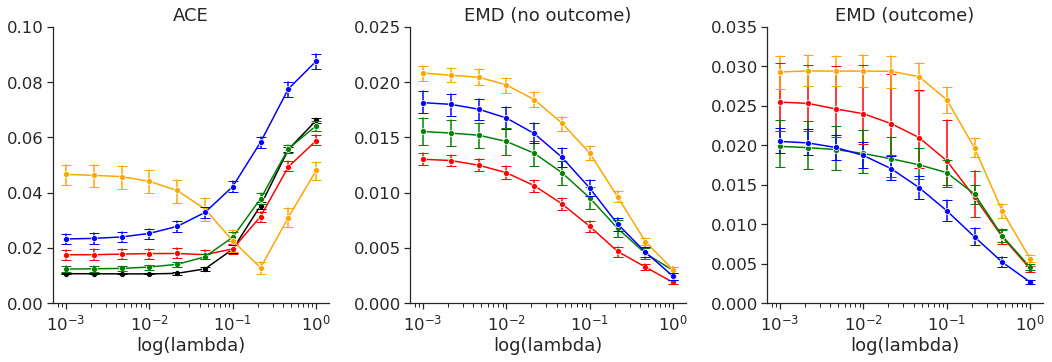

In [11]:
sns.set(font_scale=1.5)
sns.set_style("ticks")
g = sns.relplot(data = to_plot1.query("model_type==@model_type"),
              **plot_args)

g.set(xscale="log")

(g
 .set_xlabels('log(lambda)')
 .set_ylabels('')
 .set_titles(row_template="", col_template="{col_name}")
 .set_yticklabels()
)

h = sns.relplot(data = to_plot2.query("model_type==@model_type"),
              **plot_args,
             )

h.set(xscale="log")
(h.set_xlabels('log(lambda)')
 .set_ylabels('')
 .set_titles(row_template="", col_template="{col_name}")
 .set_yticklabels()
)

# plt.legend(title='Group', labels=['all', 'Black Women', 'White Women', 'Black Men', 'White Men'],
#           bbox_to_anchor=(-0.5,-.3)) #bbox_to_anchor=(1, 1))
# sns.set(font_scale=1)


if save_plots:
    g.savefig(
        os.path.join(args['plot_path'], '_'.join(('appendix', model_type, 'general_metrics1.png')))
    )
    
    h.savefig(
        os.path.join(args['plot_path'], '_'.join(('appendix', model_type, 'general_metrics2.png')))
    )

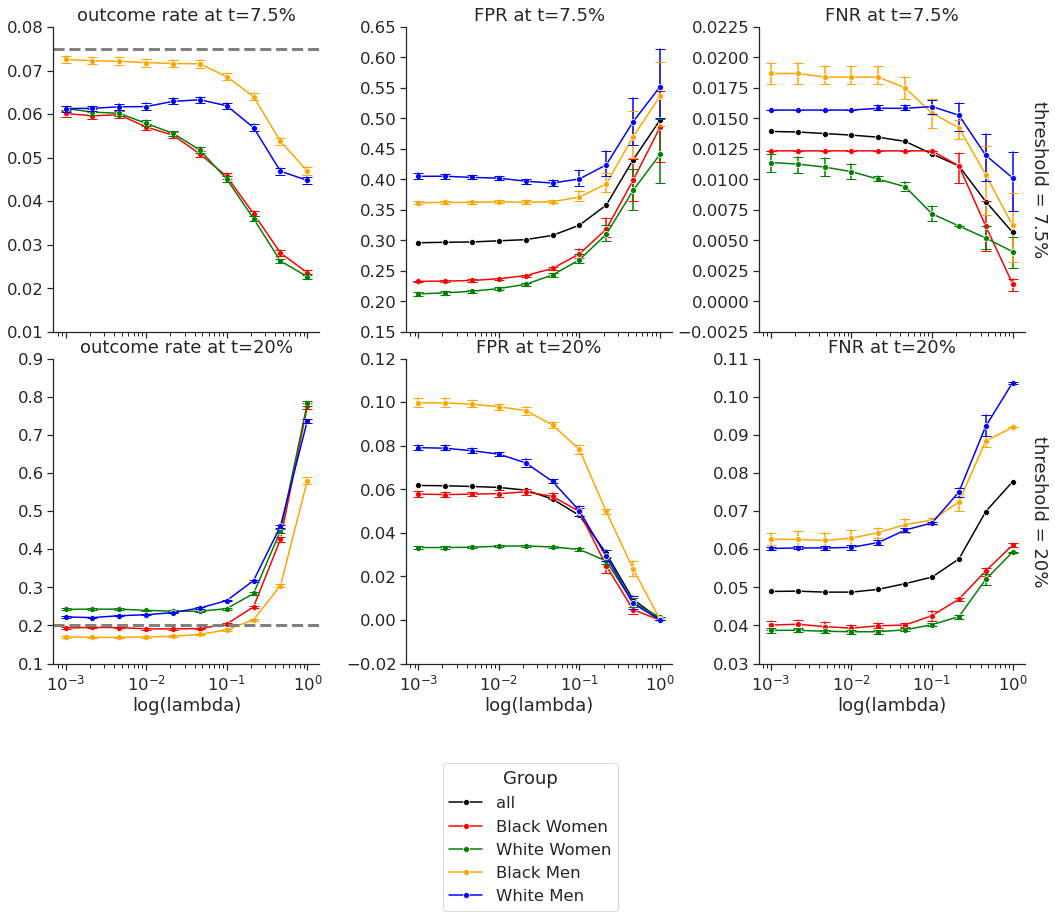

In [13]:
output_path = os.path.join(args['plot_path'], 
                           '_'.join(('appendix', model_type, 'threshold_metrics.png')
                                   )
                          )


sns.set(font_scale=1.5)
sns.set_style("ticks")

g = sns.relplot(data = df_thresholds.query("model_type==@model_type"),
                **plot_args,
                row = 'threshold',

               )
g.set(xscale="log")
(g.set_xlabels('log(lambda)')
 .set_ylabels('')
 .set_yticklabels()
)

axes = g.axes.flatten()
axes[0].axhline(0.075, ls='--', linewidth=3, color='grey')
axes[3].axhline(0.2, ls='--', linewidth=3, color='grey')

axes[0].set_title("outcome rate at t=7.5%")
axes[1].set_title("FPR at t=7.5%")
axes[2].set_title("FNR at t=7.5%")
axes[3].set_title("outcome rate at t=20%")
axes[4].set_title("FPR at t=20%")
axes[5].set_title("FNR at t=20%")

plt.legend(title='Group', labels=['all','Black Women', 'White Women', 'Black Men', 'White Men'],
           bbox_to_anchor=(-0.5,-.3)) 

sns.set(font_scale=1)

if save_plots:
    g.savefig(output_path)